# Modeling a solid tumor via a Cellular Automaton

This work deals with mathematical modeling of tumour growth, we present an example of a model of a solid cancer tumour and this modeling uses cellular automata which is consider as a grid of size $N\times N$. We begin the simulation with four proliferating cancer stem cells which reside in the centre of the grid of the Cellular Automaton and they react with the environment via certain partial differential equations (PDEs). We show how these proliferating cells develop by consumption and production of nutrients in the medium (oxygen, glucose, hydrogen), and how it react with the constraint ECM by secreting MDE, and the decision of life cycle of each cells is taken by neural network which takes the last chemicls filed concentrations as a input data.
The multiplication of the cells introduces new proliferating cells, quiescent, necrotic or in apopotosis.

After the tumour has reached to a certain size the process of formation of new blood vessels (angiogenesis) re-supply the tumour with sufficient nutrients for growth, and this process enlarge the probability of occurrence of bad mutation.

The primary objective of this part is to present the function of the cellular automaton and the evolution of the tumour and regarding the results. We applied the simulations using SageMath sofware which provides us with a number of software, libraries and functions that solve our problem.

## 1. Avascular stage 
In this stage the cell react with the envoirement, the neural network takes the decision of the phenotypw with consideration that the cell can only move or proliferate only if there are empty adjacent lattice in addition of the availability of sufficient nutrients and if this condition is not available the cell become quiessence. The type of the cell, cancer stem cell (CSC) or cancer non stem cell (CC) affect the life cycle decision as result of the various biological properties of each type. And the density of cells in each grid in this stage take the value 1 if the lattice is occupied by cell and the value $0$ if not.

In [33]:
#!pip install sympy

* First at all we import all the package data that we need

In [34]:
import sympy as sp
from math import floor
import numpy as np
import matplotlib.pylab as plt
import operator
import random
import matplotlib
import math
%matplotlib inline 

### 1.1 Insertion the input data

We in enter the input data which is needed for beginning the simulation, we insert:
* the sixe of the grid, and we pose to make the simulation in the three-quarters of the grid to ensure the sherique form of the tumor in the end of the simulation.
* space step which is depended in real size of the single cell , and the length scale.
* the time step which depending in number of steps of the simulation, and the time scale which is taken as the average time of cell cytle.
* the probability of symetric division of the CSC and the number of oucciped adjcant places.
* we define two trait vector depend on cell type, which have information about biological properties like proliferation age, proliferation potential, internal adhesion value, spontaneous death probability , and boolean case to describe the type of the cell.

In [35]:
GS_N=400  #Size of grid.
N= int (GS_N*3/4)  #Condition to have the spherical form of tumour.
H=0.0025  #Space step.
dt=1/(150*24) #Time step.
tau= 16  #Time scale.
L=2  #Length scale.
N1 = 3    #Number of occupied adjacent places of the first cells.
V0=[16, +sp.oo, 3, 0, True]  #trait vector for CSC.
rho=10  #Initial proliferative potential of CCs.
spd=0.01  #Spontaneous death probability
V1=[16, rho, 3, spd, False] #trait vector for CC.

* The necessary data for solving the partial differential equations the diffusion constants, the consumption, production, or the decay rate of the chemicals
* for calcualting the movement probabilities we need the haptotaxis or chemotaxis coefficient. 

In [36]:
Dc=1.8*10**(-5)    #Oxygen diffusion constant.
dc=Dc*tau/L**(2)
Dm=10**(-9)        #MDE diffusion constant.
dm=Dm*tau/L**(2)
Dg=9.1*10**(-5)    #Glocose diffusion constant.
dg=Dg*tau/L**(2)
Dh=1.1*10**(-5)    #Hydrogen diffusion constant.
dh=Dh*tau/L**(2)
vc=0               #Production term of oxygen.
wc=10              #Uptake constant of oxygen.
phi=0.025          #Decay constant of oxygen.
alpha=0.1          #Production constant of MDE.
wm=0.01            #Uptake constant of MDE.
nf=50              #Decay constant of ECM.

rg=0.007           #Uptake rate of glocose.
rh=0.007           #Production rate of hydrogen.

dn=0.001           #Random diffusion constant.
xh=0.01            #Haptotaxis constant.
xc=0.02            #Chemotaxis constant.

Ps = 0.8           #Symmetric division probability.
P_m_1=0.01         #Probability of mutaion.

kem1 = dt*H**(-2)
kem2 = dn*kem1
kem3 = kem1*xh/8
c_1 = kem2
c_2 = kem3

In [37]:
dg

0.000364

### 1.2 Updating the chemical fields
We update the chemical fields for all living cells by the solving the partial differential equations each time step using Euler finite difference approximations.

The system of  partial differential equations:
\begin{equation}
\begin{aligned}
 \frac{\partial f}{\partial t} & = \overbrace{-\delta.m.f}^{degradation}\\
 \frac{\partial m}{\partial t} & = \overbrace{D_{m}.\nabla^{2}{m}}^{diffusion}+\overbrace{g(n,m)}^{production}-\overbrace{h(n,m,f)}^{decay} \\
 \frac{\partial c}{\partial t} & = \overbrace{D_{c}.\nabla^{2}{c}}^{diffusion}+\overbrace{\beta.f}^{production}-\overbrace{\gamma.n}^{uptake}-\overbrace{\alpha.c}^{decay}\\
 \frac{\partial g}{\partial t} & = D_g.\nabla^{2}{g}(\vec x,t)-f_{g}(\vec x,t)\\
 \frac{\partial h}{\partial t} & = D_h.\nabla^{2}{h}(\vec x,t)+f_{h}(\vec x,t)
\end{aligned}
\end{equation}
where f, m , c, g, h describe ECM, MDE, oxygen , glucose and hydrogen concentration respectively.


#### Explaining briefly the Euler finite difference approximations:


In [38]:
def chemical_fields (L1,AC,f,m,C,g,h):
    m_1=m
    C_1=C
    f_1=f
    g_1=g
    h_1=h
    cst=8*dt*H**(-2)
    for k in range (len(L1)):
        L1[k][3]=0
        i,j=L1[k][0]
        if (L1[k][1]== "Necrotic")==True:
            d_c=0
        elif (L1[k][1]=="Black")==True:
            d_c=0
        else:
            Lpp=[(i+e,j+ee) for e,ee in zip ([1,0,0,1,1,-1,-1,+1],[0,1,-1,0,1,1,-1,-1]) if 0<=i+e<N if 0<=j+ee<N]
            f[i,j] = ((f_1[i,j]*(1-(dt*nf*m_1[i,j]))))
            m[i,j] = m_1[i,j]*(1-(cst*dm)-wm*dt)+dt*alpha
            C[i,j] = C_1[i,j]*(1-dc*cst-phi*dt)+vc*dt*f_1[i,j]-wc*dt
            g[i,j] = g_1[i,j]-rg-dg*cst*g_1[i,j]
            h[i,j] = h_1[i,j]+rh-dh*cst*h_1[i,j]
            for x in Lpp:
                L1[k][3] += AC[x[0],x[1]]
                m[i,j] += dm*(cst/8)*(m_1[x[0],x[1]])

                C[i,j] += dc*(cst/8)*(C_1[x[0],x[1]])

                g[i,j] += dg*(cst/8)*(g_1[x[0],x[1]])


                h[i,j] += dh*(cst/8)*(h_1[x[0],x[1]])
    #print (C)
    return (C,g,h,m,f,L1)

### 1.3 Test of the phenotype by the thresholds of the model
The firet test determine the phenotype depending on the thresholds of the model, that decide to change the phenotype of the cell to Necrotic as result of insufficient nutrient or to become quiescent due to no adjcant empty place is available.

In [39]:
def test_one (L1 ,k,i,j):
    test=0
    if C[i,j]<0.15 or h[i,j]>7.1 or g[i,j]<0.43:
        #Netrotic
        L1[k][1]="Necrotic"
        test=1
    elif L1[k][3]== 8:
        #Quisescence
        test=2
    return (test)

### 1.4 Neural network role and mutation
The neural network aim to make the link between the environment (nutrients), the genotype and the phenotype of the cell, which is described as 3 layer contain nodes have vales, and the connexion between the nodes are two Synaptic weight matrices. The neural network decide the decision that determine the phenotype of the cell. The modeling of a neural network depends on the choice of a transfer function: $T(x)=\dfrac{1}{1+e^{-2x}}$ , to ensure the node vales is in the interval $[0.1]$
* Impact of the mutations:

When the cells divide, the network parameters are copied to the daughter cell under mutations, if the cell is a mutated cell, the number of mutation is chosen from a Poisson distribution and the incorrect copying is modelled by adding a normal distributed number with strengh $\sigma=0.25$
to the daughter cell matrix, and this will impact the decision of the phenotype from the network.

In [40]:
def transfert (x):
    return (1/(1+np.exp(-2*x)))

* The input layer of the neural network have the value of chemicals, which are the result of solving the PDEs, and the number of adjacent neighbor.
* The hidden layer contain the regulatory genes which can be determined by: $V_{j}=T(\sum_{k}\omega_{jk}\xi_{k}-\theta_{j})$
* The output layer determine the output phenotype by: $ Y_{i}=T(\sum_{j}W_{ij}V{j}-\phi_{i})$

the neural network choose the maximum value of output layer and decide to take its phenotype

In [41]:
def network_decision (L1,k):
    maxi=[]
    #for k in range (len(L1)):
    i,j = L1[k][0]
    theta = [0.55, 0, 0.7, -0.25 ]
    W_RN = np.array([[-0.5,1,-0.5,0], [0,0.5,-0.5,0]])
    #w_RN = np.array([[-1,0,0,0,0,0], [0.5,0,0,0,0,0],[0,-2,0,0,1,1],[0,0,-2,0.5,0,0]])
    w_RN = np.array([[-1,1,0,0,0,2], [1,1,0,0,0,-1],[0,-2,0,0,1,1],[0,0,-2,0.5,0,0]])
    V = [transfert (L1[k][3]),(C[i,j]),(g[i,j]),(h[i,j]),(m[i,j]),(f[i,j])]
    if L1[k][4] == False:
        W_RN = np.array([[-0.5,1,-0.5,0], [0,0.5,-0.5,0]])
    else:
        nbr_mutation=np.random.poisson(2)
        for ii in range (nbr_mutation):
            s=np.random.normal(0.25,0.25)
            x_1,x_2=np.random.choice(range(1)),np.random.choice(range(3))
            W_RN[x_1,x_2] += s

    a = np.dot( w_RN,V)-theta
    V=transfert (a)
    b=np.dot(W_RN,V)
    Y=transfert (b)
    #print (Y)
    max_index, max_value = max (enumerate (Y), key=operator.itemgetter(1))
    maxi.append(max_index)
    return(maxi)

### 1.5 Proliferation
If the proliferation has the maximum value in the output layer of the network, the cell decide to make mitosis under certain conditions depending in the cell type CC or CSC.
The cell check if there are empty place around it, then if it find places it can complete the mitosis. One of daughter cells is occupying the mother place and the other cell chooses in random a adjacent lattice and move to it 
* if the cell is a CSC:

with the probability of the symmetric division if the result chooses to do symmetric division the CSC choose a random adjacent empty place and it divide to two CSC, and if the result chooses to do asymmetric division the CSC divide to CSC which stay at the mother lattic and the other cell is CC with deffrent type and biological properties from the mother cell , so the CC will have diffrent trait vector 
* if the cell is a CC:

the cell need first to check that its proliferation potential is bigger than 0, or it will become quiessence, then it divide to two CC and reduce for both of new cells there proliferation potential by 1.

In [42]:
def L_p_p(i,j,N):
    Lpp=[(i+e,j+ee) for e,ee in zip ([-1,0,0,1,1,-1,-1,+1],[0,1,-1,0,1,1,-1,-1]) if 0<=i+e<N if 0<=j+ee<N]
    return(Lpp)

In [43]:
def choose_place (ii,jj,AC,N):
    Lpp=L_p_p(ii,jj,N)
    LV = [[kk,ll] for kk,ll in Lpp if AC[kk,ll]==0]
    if len(LV)==0:
        #print ("Quiescence")
        return ([],False)
    else:
        #choose place
        return(LV [ np.random.choice(len(LV))], True)

In [44]:
def mitosis_under_mutation(m,P_m_1):
    if np.random.uniform (0,1) < P_m_1:
        m=1
    else:
        m=0
    return (m)

In [45]:
def proliferation_test(k,i,j,L1,L2,AC,BC,m,mm,P_m_1,Ps):
    i,j=L1[k][0]
    if choose_place(i,j,AC,N)[1]== True:
        if L1[k][2][4]== True:
            #CSC
            if np.random.uniform (0,1) > Ps:
                #asymetric divisoin
                n_1,n_2 = choose_place(i,j,AC,N)[0]
                AC[n_1,n_2] = 1
                m[n_1,n_2] = mm
                L2.append([[i,j], "red", V0,L1[k][3],L1[k][4]])
                BC[i,j]="red"
                if mitosis_under_mutation(0,P_m_1)== 0:
                    L2.append([[n_1,n_2], "red", V1,L1[k][3],L1[k][4]])
                else:
                    L2.append([[n_1,n_2], "red", V1,L1[k][3],True])
                BC[n_1,n_2]="red"
            else:
                #symetric divisoin
                # chose new place for new cell
                n_1,n_2 = choose_place(i,j,AC,N)[0]
                AC[n_1,n_2]= 1
                m[n_1,n_2]= mm
                L2.append([[i,j], "red", V0,L1[k][3],L1[k][4]])
                BC[i,j]="red"
                if mitosis_under_mutation(0,P_m_1)== 0:
                    L2.append([[n_1,n_2], "red", V0,L1[k][3],L1[k][4]])
                else:
                    L2.append([[n_1,n_2], "red", V0,L1[k][3],True])
                BC[n_1,n_2]="red"
        else:
            if L1[k][2][1]<=0:
                L2.append ([[i,j], "green", V0,L1[k][3],L1[k][4]])
                BC[i,j]="green"
            else:
                #CC symetriqu division
                L1[k][2][1]=L1[k][2][1]-1
                Vr=L1[k][2]
                n_1,n_2 = choose_place(i,j,AC,N)[0]
                AC[n_1,n_2]= 1
                m[n_1,n_2]= 0.5
                L2.append([[i,j], "red", Vr,L1[k][3],L1[k][4]])
                BC[i,j]="red"
                BC[n_1,n_2]="red"
                if mitosis_under_mutation(0,P_m_1)==0:
                    L2.append([[n_1,n_2], "red", Vr,L1[k][3],L1[k][4]])
                else:
                    L2.append([[n_1,n_2], "red", Vr,L1[k][3],True])
    else:
        L1[k][1]="green"
        L2.append (L1[k])
        BC[i,j]="green"
    return (AC,BC,L1,L2,m)

### 1.6 Mouvement
If the quiessence has the maximum value in the output layer of the network, the cell decide to move if there are activation of the mouvement, and that's depend on the internal adhesion value from cells' trait vector, so if the internal adhesion value is smaller than number of adjacent cells the mouvement activation happen and the cell move can move to empty adjacent lattice.
We need to calculate the probabilty of mouvement to all diagonal and orthogonal adjacent neighbor which can be described as the sum of the random motility and direct motility as result of degrading the ECM. Then by those probability we can determine the direction of movement usieng methode alpha.
* The probabilties of mouvement to diagonal and orthogonal adjacent neighbor:
\begin{equation}
\begin{aligned}
P_1= & \frac{kD_n}{h^2}-\frac{k\rho_{hapt}}{8h^2}(f_{i+1,j}^{q}-f_{i-1,j}^{q})\\
P_2= & \frac{kD_n}{h^2}+\frac{k\rho_{hapt}}{8h^2}(f_{i+1,j}^{q}-f_{i-1,j}^{q})\\
P_3= & \frac{kD_n}{h^2}-\frac{k\rho_{hapt}}{8h^2}(f_{i,j+1}^{q}-f_{i,j-1}^{q})\\
P_4= & \frac{kD_n}{h^2}+\frac{k\rho_{hapt}}{8h^2}(f_{i,j+1}^{q}-f_{i,j-1}^{q})\\ 
P_5= & \frac{kD_n}{h^2}-\frac{k\rho_{hapt}}{8h^2}(f_{i+1,j-1}^{q}-f_{i-1,j+1}^{q})\\ 
P_6= & \frac{kD_n}{h^2}+\frac{k\rho_{hapt}}{8h^2}(f_{i+1,j-1}^{q}-f_{i-1,j+1}^{q})\\
P_7= & \frac{kD_n}{h^2}-\frac{k\rho_{hapt}}{8h^2}(f_{i+1,j+1}^{q}-f_{i-1,j-1}^{q})\\ 
P_8= & \frac{kD_n}{h^2}+\frac{k\rho_{hapt}}{8h^2}(f_{i+1,j+1}^{q}-f_{i-1,j-1}^{q})
 \end{aligned}
\end{equation}

In [46]:
def mouvement (k,i,j,AC,BC,L1,f,L2,mm,N):
    #i,j=L[k][0]
    nv=0 #we pose first that number of oucciped adjcant places is zero
    Lpp=L_p_p(i,j,N)

    for x in Lpp:
        nv += AC[x[0],x[1]] #for updating the number of oucciped places
    if L1[k][2][2]<=nv:
            #on calculer les P_i
        if ([i+1,j] and [i-1,j] and [i,j+1] and [i,j-1] and [i+1,j-1] and [i-1,j+1] and [i-1,j-1] and [i+1,j+1] in Lpp)==True:
            in1=f[i+1,j]-f[i-1,j]
            in2=f[i,j+1]-f[i,j-1]
            in3=f[i+1,j-1]-f[i-1,j+1]
            in4=f[i+1,j+1]-f[i-1,j-1]
            inl=[in1,in2,in3,in4,in5]
            coff_L=np.array([[1,-1],[1,1]])
            P_list=[np.dot(coff_L,[1,inl[s]]) for s in [0,1,2,3]]
            P_1,P_2=P_list[0]
            P_3,P_4=P_list[1]
            P_5,P_6=P_list[2]
            P_7,P_8=P_list[3]
            P_0=1-(P_1+P_2+P_3+P_4+P_5+P_6+P_7+P_8)

        if ([i+1,j] and [i-1,j] in Lpp)==False:
            P_1=c_1
            P_2=c_1
        elif ([i+1,j] in Lpp)==False:
            P_1=c_1-c_2*(-f[i-1,j])
            P_2=c_1+c_2*(-f[i-1,j])
    
        else: #([i-1,j] in Lpp)==False:
            P_1=c_1-c_2*(f[i+1,j])
            P_2=c_1+c_2*(f[i+1,j])
     
        
        if ([i,j+1] and [i,j-1] in Lpp)==False:
            P_3=c_1
            P_4=c_1
        
        elif ([i,j-1] in Lpp)==False:
            P_3=c_1-c_2*(f[i,j+1])
            P_4=c_1+c_2*(f[i,j+1])
        
        else: #([i,j+1] in Lpp)==False:
            P_3=c_1-c_2*(-f[i,j-1])
            P_4=c_1+c_2*(-f[i,j-1])
         
        if ([i-1,j+1] and [i+1,j-1] in Lpp)== False:
            P_5=c_1
            P_6=c_1
        elif ([i-1,j+1] in Lpp)==False:
            P_5=c_1-c_2*(f[i+1,j-1])
            P_6=c_1+c_2*(f[i+1,j-1])
        else: #([i+1,j-1] in Lpp)==False:
            P_5=c_1-c_2*(-f[i-1,j+1])
            P_6=c_1+c_2*(-f[i-1,j+1])

        if ([i+1,j+1] and [i-1,j-1] in Lpp)==False:
            P_7=c_1
            P_8=c_1
        elif ([i+1,j+1] in Lpp) == False:
            P_7=c_1-c_2*(-f[i-1,j-1])
            P_8=c_1+c_2*(-f[i-1,j-1])
        else: #([i-1,j-1] in Lpp)==False:
            P_7=c_1-c_2*(f[i+1,j+1])
            P_8=c_1+c_2*(f[i+1,j+1])
        P_0=1-(P_1+P_2+P_3+P_4+P_5+P_6+P_7+P_8)
        #print (P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_0)
        #on calculer R_i
        S=[P_0,P_1,P_2,P_3,P_4,P_5,P_6,P_8]
        R_0=[0,S[0]]
        T=[R_0]
        for s in range (1,8):
            R_s=[T[s-1][1],T[s-1][1]+S[s]]
            T.append (R_s)
        uu= np.random.uniform (0,1)
        if uu < T[0][1]:  #no mouvement
            L1[k][1]= "green"
            L2.append (L1[k])
            BC[i,j]="green"
            #print ("the cell will not move")
        elif uu >= T[1][0] and uu <T[1][1]  and 0<=i-1<N and 0<=j<N and AC[i-1,j]==0 : #move left
            AC[i,j] = 0
            AC[i-1,j] = 1
            m[i-1,j] = mm
            L1[k][0]= [i-1,j]
            L2.append (L1[k])
            BC[i,j]= 0
            BC[i-1,j]="green"
        elif uu >= T[2][0] and uu < T[2][1] and 0<=i+1<N and 0<=j<N and AC[i+1,j]==0 : #move right
            AC[i,j]= 0
            AC[i+1,j]=1
            m[i+1,j]= mm
            L1[k][0]=[i+1,j]
            L2.append (L1[k])
            BC[i+1,j]="green"
            BC[i,j]= 0
        elif uu >= T[3][0] and uu < T[3][1] and 0<=i<N and 0<=j-1<N and AC[i,j-1]==0:  #move down
            AC[i,j]= 0
            AC[i,j-1]=1
            m[i,j-1]= mm
            L1[k][0]=[i,j-1]
            L2.append (L1[k])
            BC[i,j-1]="green"
            BC[i,j]= 0
        elif uu >= T[4][0] and uu < T[4][1] and 0<=i<N and 0<=j+1<N and AC[i,j-1]==0 :  #move up
            AC[i,j]= 0
            AC[i,j+1]=1
            m[i,j+1]= mm
            L1[k][0]=[i,j+1]
            L2.append (L1[k])
            BC[i,j+1]="green"
            BC[i,j]= 0
        elif uu >= T[5][1] and uu < T[5][1] and 0<=i-1<N and 0<=j+1<N and AC[i-1,j+1]==0:  #move up left
            AC[i,j]= 0
            AC[i-1,j+1]=1
            m[i-1,j+1]= mm
            L1[k][0]=[i-1,j+1]
            L2.append (L1[k])
            BC[i-1,j+1]="green"
            BC[i,j]= 0
        elif uu >= T[6][0] and uu < T[6][1] and 0<=i+1<N and 0<=j-1<N and AC[i+1,j-1]==0:  #move down right
            AC[i,j]= 0
            AC[i+1,j-1]=1
            m[i+1,j-1]= mm
            L1[k][0]=[i+1,j-1]
            L2.append (L1[k])
            BC[i+1,j-1]="green"
            BC[i,j]= 0
        elif uu >= T[7][0] and uu < T[7][1]  and 0<=i-1<N and 0<=j-1<N and AC[i-1,j-1]==0:  #move down left
            AC[i,j]= 0
            AC[i-1,j-1]=1
            m[i-1,j-1]= mm
            L1[k][0]=[i-1,j-1]
            L2.append (L1[k])
            BC[i-1,j-1]="green"
            BC[i,j]= 0
        elif uu >= T[7][1] and 0<=i+1<N and 0<=j+1<N and AC[i+1,j+1]==0 :  #move up right
            AC[i,j]= 0
            AC[i+1,j+1]=1
            m[i+1,j+1]= mm
            L1[k][0]=[i+1,j+1]
            L2.append (L1[k])
            BC[i+1,j+1]="green"
            BC[i,j]= 0
        else:
            AC[i,j]= 1
            L2.append (L1[k])
            BC[i,j]="green"
        
    else:
        L1[k][1]="green"
        L2.append (L1[k])
        BC[i,j]="green"
    return (AC,BC,L1,L2,m)

### 1.7 Life cycle of the tumour
In each step of the simulation:
* For all lattice in the grid that occupied by a cell, we update the chemicals fields
* For all the living cell in the grid we choose in random one by one a cell and make those steps:

    * First we test the occurrence of the spontaneous death which depend on the probability of spontaneous death from the trait vector 
    * Then we make the first test that determine the phenotype by the thresholds of the model
    * Finaly the neural network takes the decision depending in the last updating of the chemicals, and it decide the phenotype of the cell to become quiescent, proliferating or to die due to apoptosis.
    
if the network decide to make proliferation, then a test that checks if the cell has reached to its proliferation age or not, so it can mitosis if it only if it reached to this age.

This test done by picking randomly from $\mathcal{N}(A_p,A_p/2)$ normal distribution with $A_p$ is the proliferation age from the trait vector, every time step the cell is
updated an internal counter $X_p$ and compared it with its proliferation age to decide to mitosis or not.


* We save all new cells in the list for preparing them to the next step of the simulation

In [47]:
def life_cycle (L1,m,f,g,h,C,BC,AC,L2,mm,N,P_m_1,Ps):

    C,g,h,m,f,L1=chemical_fields (L1,AC,f,m,C,g,h)
    random.shuffle(L1)
    L_test=L1
    for k in range (len(L_test)):
        i,j=L_test[k][0]
        if (L_test[k][1]== "Necrotic") == True:
            #print ("this cell is dead")
            L2.append (L1[k])
        elif (L_test[k][1]=="Black")== True:
            L2.append (L1[k])
        else:
            #spontanous death test:
            if np.random.uniform (0,1) < L_test[k][2][3]:
                L1[k][1]="Black"
                L2.append(L1[k])
                BC[i,j]="Black"
            else:
                t=test_one (L1,k,i,j)
                if t==1:
                    L1[k][1]="Necrotic"
                    BC[i,j] = "Necrotic"
                    L2.append(L1[k])

                elif t==2:
                    L1[k][1]="green"
                    BC[i,j] = "green"
                    L2.append(L1[k])
                else:
                    nd=network_decision(L1,k) #output must be max_index

                    if nd[0]==1: #quiessence with probability 80%
                        if np.random.uniform (0,1) >= 0.2:
                            AC,BC,L1,L2,m=mouvement (k,i,j,AC,BC,L1,f,L2,mm,N)
                        else:
                            if np.random.normal(L_test[k][2][0],L_test[k][2][0]/2) < L_test[k][2][0]:
                                #this cell is quiessence
                                AC,BC,L1,L2,m=mouvement (k,i,j,AC,BC,L1,f,L2,mm,N)

                            else:
                                #print ("Proliferation test")
                                AC,BC,L1,L2,m=proliferation_test(k,i,j,L1,L2,AC,BC,m,mm,P_m_1,Ps)


                    else: #nd[0]==0: #proliferation with probability 80%
                        if np.random.uniform (0,1) >= 0.2:
                            if np.random.normal(L_test[k][2][0],L_test[k][2][0]/2) < L_test[k][2][0]:
                                #this cell is quiessence
                                AC,BC,L1,L2,m=mouvement (k,i,j,AC,BC,L1,f,L2,mm,N)
                            else:
                                #print ("Proliferation test")
                                AC,BC,L1,L2,m=proliferation_test(k,i,j,L1,L2,AC,BC,m,mm,P_m_1,Ps)

                        else:
                            AC,BC,L1,L2,m=mouvement (k,i,j,AC,BC,L1,f,L2,mm,N)

    L1=L2
    L2=[]
    ss=len(L1)
    return (L1,L2,ss,C,h,g,f,m,AC,BC)

# Simulation of the tumor in the Avascular stage

 We repeat the life cycle steps $q$ time for all the cells, we begin with 4 CSC and we regard the evolution of growth of tumor and enlarge the number of tumor cells with different types and pheno type, and then plotting the result to have figure of the avascular tumour

In [48]:
def input2 (N,cc,ff): #it takes as parameters the size of the grid the oxygen and density level 
    AC= np.zeros((N,N))#initilaze the grid with zeros
    NN= int (floor(N/2)) #find the middle of the grid
    AC[NN,NN]=1
    AC[NN,NN-1]=1
    AC[NN-1,NN]=1
    AC[NN-1,NN-1]=1

    L1=[[[i,j], "red", V0, N1,False] for i in range (N) for j in range (N) if AC[i,j]==1]  #we initiliaze L1 with 4 Csc
    L2=[]

    BC=np.chararray((N,N))
    NN= int (floor(N/2))
    BC[NN,NN]="red"
    BC[NN,NN-1]="red"
    BC[NN-1,NN]="red"
    BC[NN-1,NN-1]="red"

    C=cc*np.ones((N,N))    #oxygen initail values for all position at time 0
    f=ff*np.ones((N,N))  #ECM initail values for all position at time 0
    g=np.ones((N,N)) #glocose initail values for all position at time 0
    h=np.ones((N,N)) #hydrogen initail values for all position at time 0

    mm=0.5 #with mm is the initial value of m, we need this to update the proliferation wnd mouvment test

    m=np.zeros((N,N))    #MDE initail values for all position that occupied by cancer cell at time 0
    NN= int (floor(N/2))
    m[NN,NN]=mm
    m[NN,NN-1]=mm
    m[NN-1,NN]=mm
    m[NN-1,NN-1]=mm
    return (AC,BC,f,C,m,g,h,L1,L2,mm)

we will repeat the simulation q times and show the tumor for diffrent times 

this is the simulation for t= 30


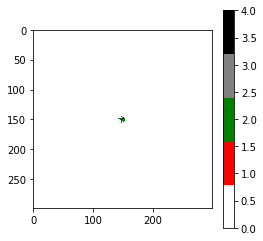

this is the simulation for t= 100


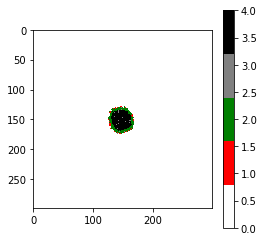

this is the simulation for t= 200


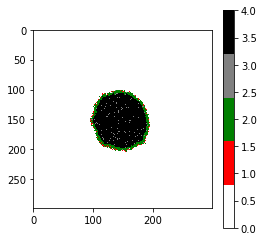

In [19]:
AC,BC,f,C,m,g,h,L1,L2,mm=input2(N,0.2,1.2)
time=[0]
NB_Cells=[4]
t=0
for q in range(400):
    L1,L2,ss,C,h,g,f,m,AC,BC=life_cycle (L1,m,f,g,h,C,BC,AC,L2,mm,N,0.2,0.2)
    t=t+1
    time.append (t)
    nbc=len(L1)
    NB_Cells.append (nbc)
    if nbc>20000:
            break
    if t==30 or t==100 or t==200:
        print("this is the simulation for t=",t)
        MM=np.zeros((N,N))
        for k in range (len(L1)):
            if L1[k][1]=="red":
                i,j=L1[k][0]
                MM[i,j]=1
            elif L1[k][1]=="green":
                i,j=L1[k][0]
                MM[i,j]=2
            elif L1[k][1]=="Black":
                i,j=L1[k][0]
                MM[i,j]=3
            else: #L1[k][1]=="Necrotic":
                i,j=L1[k][0]
                MM[i,j]=4
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)

        cmap= matplotlib.colors.ListedColormap(['white','red','green', 'grey','black'])
        plt.imshow(MM, interpolation='none', cmap=cmap)
        plt.axis([0, N-1, N-1, 0])
        #plt.grid(True)
        plt.colorbar()
        plt.show()

# Changing the tumor morphology 

hypothesis: to change the tumor morphology we need to kill necrotic cells with diffrent percentages

## Deleting cells randomly 

Methodology:
    In this part we will delete necrotic cells at a certain point in time then continue the simulation for diffrent percentages

Steps of deleting randomly necrotic cells :
1. importing the random package: This module implements pseudo-random number generators for various distributions.
2. we will count all the necrotic cells in the tissue and calculate the poucentage .
3. we will choose the cell rendomly and search for it's postion in L1 
4. we will delete the chosen cell
5. we will repeat the procedure until the number of deleted cells is equal to the pourcentage 


this is the simulation for the percentage of 20.0 %
time 200


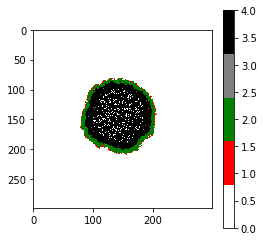

this is the simulation for the percentage of 50.0 %
time 200


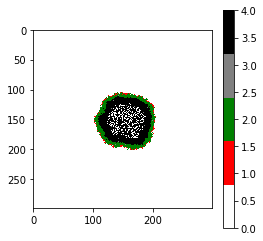

this is the simulation for the percentage of 80.0 %
time 200


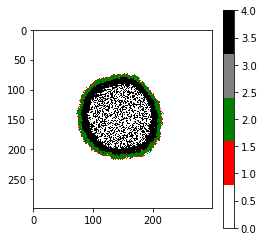

In [23]:
for p in [0.2,0.5,0.8]:#we try the simulation for diffrenf percentages 
    print("this is the simulation for the percentage of",p*100,'%')
    AC,BC,f,C,m,g,h,L1,L2,mm=input2(N,0.2,1.2)
    time=[0]
    NB_Cells=[4]
    t=0
    for q in range(203):

        L1,L2,ss,C,h,g,f,m,AC,BC=life_cycle (L1,m,f,g,h,C,BC,AC,L2,mm,N,P_m_1,Ps)
        t=t+1
        time.append (t)
        nbc=len(L1)
        t_max=q
        NB_Cells.append (nbc)
        t_exact= (t_max*tau)/24==t

        if nbc > 20000:
            print('break',q)
            break
        if t==150 :#we will delete the cells at a certain time 

            Necro=0
            pourc=0
            for k in range (len(L1)): #we will count all the necrotic cells
                if L1[k][1]=="Necrotic":
                    Necro=Necro+1
            pourc=round(Necro*p) #we will calculate the percantge of the necrotic cell 
            count=0
            pos=0
            for k in range (len(L1)):
                ch=random.choice(L1) #we will choose randomly a cell
                if ch[1]=="Necrotic": #verfy if the chosen cell is necrotic
                    count=count+1 #calculate the number of the chosen cells
                    for pp in range (len(L1)): #search for the postion of the chosen cell
                        L1[pp]==ch
                        pos=pp
                    del(L1[pos])
                    if count==pourc: #stop the deleting if the percentage is reached

                        break 




        if  t==200: #showing the simulation after a certain period of time 

            print("time",t)
            MM=np.zeros((N,N))
            for k in range (len(L1)):
                if L1[k][1]=="red":
                    i,j=L1[k][0]
                    MM[i,j]=1
                elif L1[k][1]=="green":
                    i,j=L1[k][0]
                    MM[i,j]=2
                elif L1[k][1]=="Black":
                    i,j=L1[k][0]
                    MM[i,j]=3
                else: #L1[k][1]=="Necrotic":
                    i,j=L1[k][0]
                    MM[i,j]=4

            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)

            cmap= matplotlib.colors.ListedColormap(['white','red','green', 'grey','black'])
            plt.imshow(MM, interpolation='none', cmap=cmap)
            plt.axis([0, N-1, N-1, 0])
          #plt.grid(True)
            plt.colorbar()
            plt.show()



    
    

### Results :
Deleting the necrotic cells randomly doesn't change enough the morpholgy of the cell but creats blank spaces in the necrotic area

## Deleting randomly cells that are at the extrimity of the necrotic zone 

Since in the previous method we have noticed that the deleted cells in the extremity of the necrotic layer have been replaced we chosed to delete cells only from that area with diffrent percentages.

methodologie :
in this part we will calculate two distances one in up half of the cell and another in lower half and create an interval from those two distances [mindistance , maxdistance ] then deleting cells randomly from that interval with diffrent percentages .


Steps of deleting cells in the extrimity:
1. we will calculate two distances by fixing an i and searching for the lowest j of the quiscent cell if j>N/2 and the highst j if j>N/2.
2. choose the min and max distance and build our interval 
3. choosing a cell (since L1 isn't in order the delete will be random ) until  the number of deleted cells is equal to the choosen pourcentage 

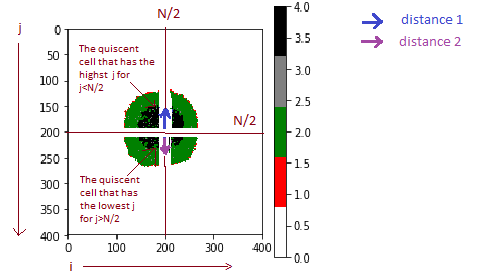

In [32]:
from IPython.display import Image
Image(filename='/Users/asus/Desktop/Distancecell.png',width=800,height=800)


In [33]:
from math import sqrt
def Sqr(a): #cette fonction retourne le carré d'un nombre
    return a*a

def Distance(x1,y1,x2,y2): #calcule la distance euclidienne 
    return sqrt(Sqr(y2-y1)+Sqr(x2-x1))

this is the simulation for the percentage of 20.0 %
this the simulation at t== 200


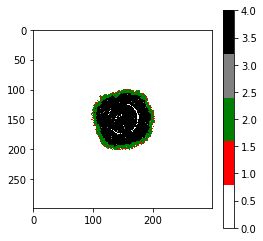

this is the simulation for the percentage of 50.0 %
this the simulation at t== 200


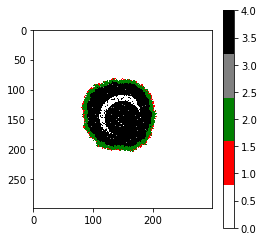

this is the simulation for the percentage of 80.0 %
this the simulation at t== 200


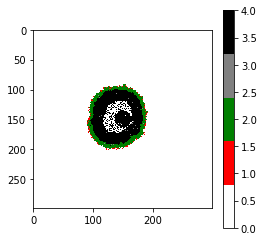

In [35]:
for p in [0.2,0.5,0.8]:#we try the simulation for diffrenf percentages 
    print("this is the simulation for the percentage of",p*100,'%')
    AC,BC,f,C,m,g,h,L1,L2,mm=input2(N,0.2,1.2)
    time=[0]
    NB_Cells=[4]
    t=0
    NN= int (floor(N/2))
    for q in range(250):

        L1,L2,ss,C,h,g,f,m,AC,BC=life_cycle (L1,m,f,g,h,C,BC,AC,L2,mm,N,P_m_1,Ps)
        t=t+1
        time.append (t)
        nbc=len(L1)
        t_max=q
        NB_Cells.append (nbc)
        t_exact= (t_max*tau)/24==t

        #if nbc > 20000:
            #print('break',q)
            #break
        dist=0
        max1=[0,0] #initlaizing with the minimum value
        if t==150:#Delleting cells on the extrimity at this time 
            for k in range (len(L1)):
                if L1[k][1]=="green": #searching for the quiscent cell 
                    if L1[k][0][0]==N/2:#fixing an i
                        if L1[k][0][1] > max1[1] and (L1[k][0][1]< N/2):  #comparing it's j with the middle of the grid 
                            max1=L1[k][0] #searching for the maximum j 

                            dist=Distance(max1[0],max1[1],NN,NN) #calculating the euclidien distance between the cell and the middle of th grid

            min1=[N,N] #initlaizing with the maximum  value
            dist2=0
            for k in range (len(L1)):
                if L1[k][1]=="green": #searching for the quiscent cell 
                    if L1[k][0][0]==N/2: #fixing an i
                        if L1[k][0][1] < min1[1] and L1[k][0][1]> N/2: #comparing it's j with the middle of the grid 
                            min1=L1[k][0] #searching for the minimum j 

                            dist2=Distance(min1[0],min1[1],NN,NN) #calculating the euclidien distance between the cell and the middle of th grid


            max2=max(dist,dist2) #comparing the two distances 
            min2=min(dist,dist2)
            count=0
            Necro=0
            pourc=0
            for k in range (len(L1)): #count the number of necrotic cells
                if L1[k][1]=="Necrotic":
                    Necro=Necro+1
            pourc=round(Necro*p) #counting the percentage 
            p=len(L1)
            L3=list(L1)
            length = len(L3)-1
            posi=0
            for k in range (length): 


                if (k<length )and ((min2)<= Distance(L3[k][0][0],L3[k][0][1],NN,NN) <= max2) : #checking if the cell is in the interval 
                     if L3[k][1]=="Necrotic" : #cheking if it's necrotic



                        length = length -1
                        count=count+1 #counting the number of cells deleted
                        posi=k-count+1

                        del(L1[posi])

                        if count==pourc:#stopping deleting the cells if the percentage is reached
                            break




        #continue the evolution of the tumor
        if t==200: #showing at this time the tumor
            print('this the simulation at t==',t)


            MM=np.zeros((N,N))
            for k in range (len(L1)):
                if L1[k][1]=="red":
                    i,j=L1[k][0]
                    MM[i,j]=1
                elif L1[k][1]=="green":
                    i,j=L1[k][0]
                    MM[i,j]=2
                elif L1[k][1]=="Black":
                    i,j=L1[k][0]
                    MM[i,j]=3
                else: #L1[k][1]=="Necrotic":
                    i,j=L1[k][0]
                    MM[i,j]=4

            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)

            cmap= matplotlib.colors.ListedColormap(['white','red','green', 'grey','black'])
            plt.imshow(MM, interpolation='none', cmap=cmap)
            plt.axis([0, N-1, N-1, 0])
          #plt.grid(True)
            plt.colorbar()
            plt.show()


### General results 


Deleting Cells creates blank spaces and don't change enough the merphologie of the tumor 

## Crushing the cells randomly

since deleting cells creates blank spaces in this part we will crush the chosen cell (randomly)  

methodolgy : The crushing is a result of comparing i of the chosen cell to N/2 the middle of the grid so if i>N/2 we will move backwards all the cells located in front of the necrotic cell but if i>N we move backwards all the cells located behind the necrotic cell

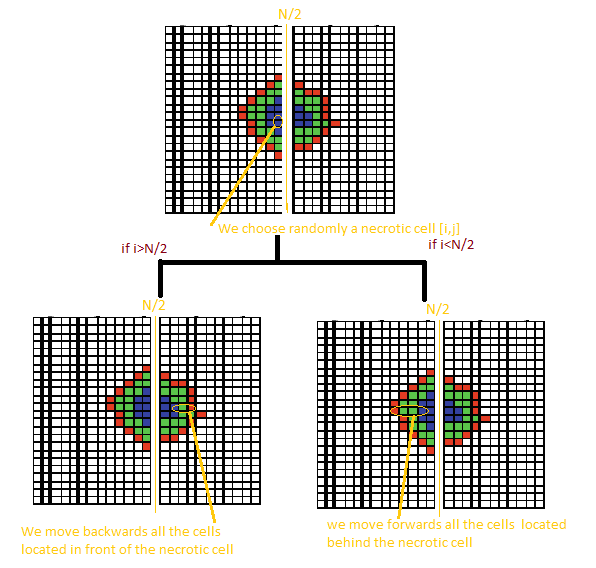

In [36]:
from IPython.display import Image
Image(filename='/Users/asus/Desktop/ImageCA.PNG',width=800,height=800)

this is the simulation for the percentage of 20.0 %


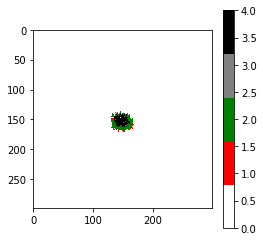

this is the simulation for the percentage of 50.0 %


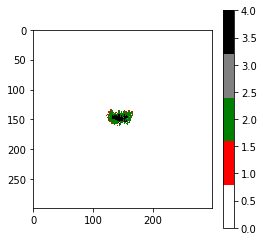

this is the simulation for the percentage of 80.0 %


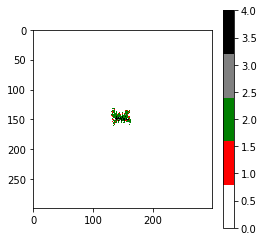

In [17]:
for p in [0.2,0.5,0.8]:#we try the simulation for diffrenf percentages 
    print("this is the simulation for the percentage of",p*100,'%')
    AC,BC,f,C,m,g,h,L1,L2,mm=input2(N,0.2,1.2)
    time=[0]
    NB_Cells=[4]
    t=0
    for q in range(150):

        L1,L2,ss,C,h,g,f,m,AC,BC=life_cycle (L1,m,f,g,h,C,BC,AC,L2,mm,N,P_m_1,Ps)
        t=t+1
        time.append (t)
        nbc=len(L1)
        t_max=q
        NB_Cells.append (nbc)
        t_exact= (t_max*tau)/24==t









        if  t==100:
            Necro=0
            pourc=0
            #print(len(L1))
            L4=list(L1)
            length=len(L4)-1
            #calculer le nombre total des celules necrotic
            for k in range (length):
                #if (k<length):
                    #print(k)
                if L4[k][1]=="Necrotic":
                    Necro=Necro+1
            #calculer le poucrntege des cellules necrotic
            pourc=round(Necro*p)
            count=0
            pos=0
            #avancer et supprimer les celules 
            while count!= pourc :
                ch=random.choice(L1)
                if ch[1]=="Necrotic":
                    count=count+1
                    #print(count)
                    #touver la postion de la cellule choisit au hasard 
                    for pp in range (len(L1)-1):
                        #pour touver la postion du ch dans L1
                        #print('this is pp',pp)
                        #print('this is len l 1',len(L1))
                        if L1[pp]==ch:
                            pos=pp
                    #deplacer les cellules        
                    if (L1[pos][0][0] < N/2):
                        for j in range (len(L1)-1):
                            if L1[j][0][1]==L1[pos][0][1]:
                                if (L1[j][0][0]<L1[pos][0][0]):
                                    L1[j][0][0]=L1[j][0][0]+1
                    else:
                        for j in range (len(L1)-1):
                            if L1[j][0][1]==L1[pos][0][1]:
                                if (L1[j][0][0]>L1[pos][0][0]):
                                    L1[j][0][0]=L1[j][0][0]-1
                    #effacer la cellules
                    del(L1[pos])



            MM=np.zeros((N,N))
            for k in range (len(L1)):
                if L1[k][1]=="red":
                    i,j=L1[k][0]
                    MM[i,j]=1
                elif L1[k][1]=="green":
                    i,j=L1[k][0]
                    MM[i,j]=2
                elif L1[k][1]=="Black":
                    i,j=L1[k][0]
                    MM[i,j]=3
                else: #L1[k][1]=="Necrotic":
                    i,j=L1[k][0]
                    MM[i,j]=4

            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)

            cmap= matplotlib.colors.ListedColormap(['white','red','green', 'grey','black'])
            plt.imshow(MM, interpolation='none', cmap=cmap)
            plt.axis([0, N-1, N-1, 0])
          #plt.grid(True)
            plt.colorbar()
            plt.show()


Crushing the cells at a certain point and continue the simulation

this is the simulation for the percentage of 20.0 %
the crushin was made at this time t== 100
this is the evolution of the simulation at this point of time t== 150
150


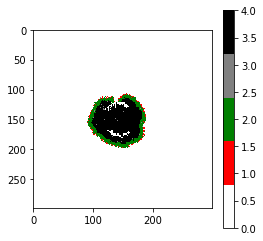

this is the simulation for the percentage of 50.0 %
the crushin was made at this time t== 100
this is the evolution of the simulation at this point of time t== 150
150


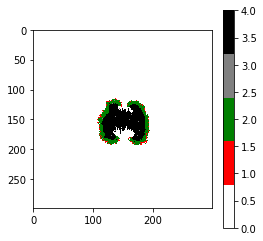

this is the simulation for the percentage of 80.0 %
the crushin was made at this time t== 100
this is the evolution of the simulation at this point of time t== 150
150


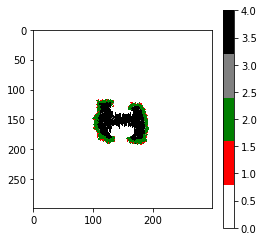

In [54]:
for p in [0.2,0.5,0.8]:#we try the simulation for diffrenf percentages 
    print("this is the simulation for the percentage of",p*100,'%')
    AC,BC,f,C,m,g,h,L1,L2,mm=input2(N,0.2,1.2)
    time=[0]
    NB_Cells=[4]
    t=0
    for q in range(170):
        L1,L2,ss,C,h,g,f,m,AC,BC=life_cycle (L1,m,f,g,h,C,BC,AC,L2,mm,N,P_m_1,Ps)
        t=t+1
        time.append (t)
        nbc=len(L1)
        t_max=q
        NB_Cells.append (nbc)
        t_exact= (t_max*tau)/24==t

        #if nbc > 20000:
            #print('break',q)
            #break






        if t==100 : #we will crush the cells at this point of time
            print('the crushing was made at this time t==',t)
            Necro=0
            pourc=0
            #print(len(L1))
            L4=list(L1)
            length=len(L4)-1
            #calculer le nombre total des celules necrotic
            for k in range (length):
                #if (k<length):
                    #print(k)
                if L4[k][1]=="Necrotic":
                    Necro=Necro+1
            #calculer le poucrntege des cellules necrotic
            pourc=round(Necro*p)
            count=0
            pos=0
            #avancer et supprimer les celules 
            while count!= pourc :
                ch=random.choice(L1)
                if ch[1]=="Necrotic":
                    count=count+1
                    #print(count)
                    #touver la postion de la cellule choisit au hasard 
                    for pp in range (len(L1)-1):
                        #pour touver la postion du ch dans L1
                        #print('this is pp',pp)
                        #print('this is len l 1',len(L1))
                        if L1[pp]==ch:
                            pos=pp
                    #deplacer les cellules        
                    if (L1[pos][0][0] < N/2):
                        for j in range (len(L1)-1):
                            if L1[j][0][1]==L1[pos][0][1]:
                                if (L1[j][0][0]<L1[pos][0][0]):
                                    L1[j][0][0]=L1[j][0][0]+1
                    else:
                        for j in range (len(L1)-1):
                            if L1[j][0][1]==L1[pos][0][1]:
                                if (L1[j][0][0]>L1[pos][0][0]):
                                    L1[j][0][0]=L1[j][0][0]-1
                    #effacer la cellules
                    del(L1[pos])


        if t==150: #showing the simulation at this point of time 
            print('this is the evolution of the simulation at this point of time t==',t)
            print(t)
            MM=np.zeros((N,N))
            for k in range (len(L1)):
                if L1[k][1]=="red":
                    i,j=L1[k][0]
                    MM[i,j]=1
                elif L1[k][1]=="green":
                    i,j=L1[k][0]
                    MM[i,j]=2
                elif L1[k][1]=="Black":
                    i,j=L1[k][0]
                    MM[i,j]=3
                else: #L1[k][1]=="Necrotic":
                    i,j=L1[k][0]
                    MM[i,j]=4



            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)

            cmap= matplotlib.colors.ListedColormap(['white','red','green', 'grey','black'])
            plt.imshow(MM, interpolation='none', cmap=cmap)
            plt.axis([0, N-1, N-1, 0])
          #plt.grid(True)
            plt.colorbar()
            plt.show()

          #if nbc <= 20000:
              #NB_Cells.append (nbc)
          #else:
              #nbc=20000
              #NB_Cells.append (nbc)

### Crushing cells that are in the extrimity of the necrotic layer

Instead of crushing cells all over the nectortic area in this part we will only crush cells in the extrimity with diffrent percentages 

this is the simulation for the percentage of 20.0 %
we have crushed  20.0 % of cells at this time 100
we will show the simulation for this time  115


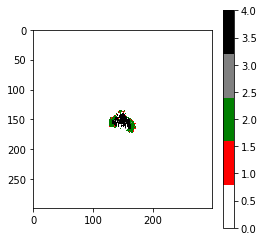

this is the simulation for the percentage of 50.0 %
we have crushed  50.0 % of cells at this time 100
we will show the simulation for this time  115


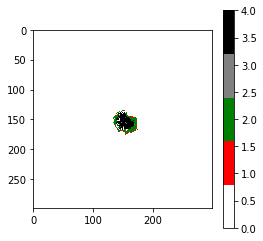

this is the simulation for the percentage of 80.0 %
we have crushed  80.0 % of cells at this time 100
we will show the simulation for this time  115


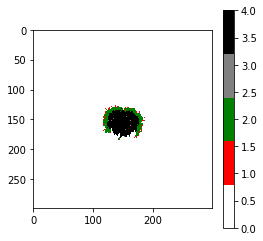

In [52]:
for p in [0.2,0.5,0.8]:#we try the simulation for diffrenf percentages 
    print("this is the simulation for the percentage of",p*100,'%')
    AC,BC,f,C,m,g,h,L1,L2,mm=input2(N,0.2,1.2)
    time=[0]
    NB_Cells=[4]
    t=0
    for q in range(200):
   
        L1,L2,ss,C,h,g,f,m,AC,BC=life_cycle (L1,m,f,g,h,C,BC,AC,L2,mm,N,P_m_1,Ps)
        t=t+1
        time.append (t)
        nbc=len(L1)
        t_max=q
        NB_Cells.append (nbc)
        t_exact= (t_max*tau)/24==t

        
        if t==100:
            print('we have crushed ',p*100,'% of cells at this time',t)
            dist=0
            max1=[0,0]
            #calculer une premiere distance de la partie superiere de la cellule
            for k in range (len(L1)):
                if L1[k][1]=="green":
                    if L1[k][0][0]==N/2:
                        if L1[k][0][1] > max1[1] and (L1[k][0][1]< N/2):
                            max1=L1[k][0]
                            #print(max1)
                            dist=Distance(max1[0],max1[1],NN,NN)
            
            min1=[N,N]
            #calculer une 2eme distance de la partie inferieure de la cellule

            dist2=0
            for k in range (len(L1)):
                if L1[k][1]=="green":
                    if L1[k][0][0]==N/2:
                        if L1[k][0][1] < min1[1] and L1[k][0][1]> N/2:
                            min1=L1[k][0]
                            #print(min1)
                            dist2=Distance(min1[0],min1[1],NN,NN)
            max2=max(dist,dist2)
            min2=min(dist,dist2)
            count=0
            Necro=0
            pourc=0
            for k in range (len(L1)):
                if L1[k][1]=="Necrotic":
                    Necro=Necro+1
            pourc=round(Necro*0.4)
            p=len(L1)
            L3=list(L1)
            length = len(L3)-1
            posi=0
            
            for k in range (length):


                if (k<length )and (min2<= Distance(L3[k][0][0],L3[k][0][1],NN,NN) <= max2) :
                     if L3[k][1]=="Necrotic" :
                        length = length -1
                        count=count+1
                        posi=k-count+1
                       
                        if (L1[posi][0][0] < N/2):
                            for j in range (len(L1)):
                                if L1[j][0][1]==L1[posi][0][1]:
                                    if (L1[j][0][0]<L1[posi][0][0]):
                                        L1[j][0][0]=L1[j][0][0]+1
                        else:
                            #si les i>N/2 on va avancer les cellules precedentes on diminuant les i


                            for j in range (len(L1)):
                                if L1[j][0][1]==L1[posi][0][1]:
                                    if (L1[j][0][0]>L1[posi][0][0]):

                                        L1[j][0][0]=L1[j][0][0]-1
                        del(L1[posi])


                        if count==pourc:
                            break
        if t==115:
            print('we will show the simulation for this time ',t)
            MM=np.zeros((N,N))
            for k in range (len(L1)):
                if L1[k][1]=="red":
                    i,j=L1[k][0]
                    MM[i,j]=1
                elif L1[k][1]=="green":
                    i,j=L1[k][0]
                    MM[i,j]=2
                elif L1[k][1]=="Black":
                    i,j=L1[k][0]
                    MM[i,j]=3
                else: #L1[k][1]=="Necrotic":
                    i,j=L1[k][0]
                    MM[i,j]=4

            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)

            cmap= matplotlib.colors.ListedColormap(['white','red','green', 'grey','black'])
            plt.imshow(MM, interpolation='none', cmap=cmap)
            plt.axis([0, N-1, N-1, 0])
                  #plt.grid(True)
            plt.colorbar()
            plt.show()







# Les courbes 

In [26]:
def simulation2 (L1,m,g,f,h,C,BC,AC,L2,mm,N,P_m_1,Ps):
    NB_Cells=[4]
    t=0
    # initilaize the lists that contains the number of cells 
    NB_proli=[4]
    NB_Qui=[0]
    NB_Necr=[0]
    NB_mut=[0]
    
    time=[0]
    for q in range(400): #the simulation is made in q steps 
        L1,L2,ss,C,h,g,f,m,AC,BC=life_cycle (L1,m,f,g,h,C,BC,AC,L2,mm,N,P_m_1,Ps)
        #number total of the cells:
        Cells_Nbr=len (L1) #contains all the number of cells 
        NB_Cells.append (Cells_Nbr)
        t=t+1
        time.append (t) #we add the time 
        #for calculating the max time that it reached to its max size
        t_max=q
        
        prof=4
        Qui=0
        Necro=0
        Apop=0
        Muteted=0
        for k in range (len(L1)):
            if L1[k][1]=="red": #calculate the number of proli cells 
                prof=prof+1 
            elif L1[k][1]=="green": #calculate the number of quiscent cells
                Qui=Qui+1
            elif L1[k][1]=="Necrotic": #calculate the number of necrotic cells
                Necro=Necro+1
            elif L1[k][1]=="blue": #calculate the number of mutated cells 
                Muteted=Muteted+1
            else:
                Apop=Apop+1
        NB_proli.append(prof) #add the number of proli cells
        NB_Qui.append(Qui)  #add the number of quiscent cells
        NB_Necr.append(Necro)  #add the number of necrotic cells
        NB_mut.append(Muteted)  #add the number of mutated cells
        
        

    ss=[0]
    d=1
    for i in range(1,len(NB_Cells)):
        ss.append(math.log(NB_Cells[i]/time[i]))  #calculate the rate growth
        #print (ss)
        d=np.abs(ss[i]-ss[i-1])
        if d<0.05:
            r=ss[i]
        else:
            r=ss[i]
    #return (r,NB_Cells,time,L1,t_max,m,g,f,h,C,BC,AC)
    return (r,t_max,NB_Cells,time,ss,NB_proli,NB_Qui,NB_Necr,NB_mut)

## Visulation des courbes pour C=0.2 et f=1.2 


In [27]:
import math

In [50]:
AC,BC,f,C,m,g,h,L1,L2,mm=input2(N,0.2,1.2)
r,t_max,NB_Cells,time,ss,NB_proli,NB_Qui,NB_Necr,NB_mut=simulation2 (L1,m,g,f,h,C,BC,AC,L2,mm,N,P_m_1,Ps) #To have the lists that have the numbr of every cell type and the time of the simulation 

Time according to the number of proliferating cells in blue and mutated cells in orange 

(0, 1400)

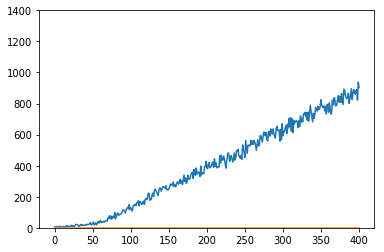

In [51]:
plt.plot(time,NB_proli,time,NB_mut)
matplotlib.pyplot.ylim(0,1400)

Time according to the number of quiscent cells in blue and necrotic cells in orange 

(0, 100000)

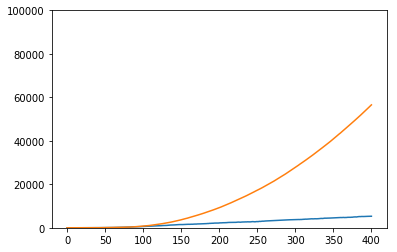

In [52]:
plt.plot(time,NB_Qui,time,NB_Necr)
matplotlib.pyplot.ylim(0,100000)

## Visulation des courbes pour C=1.2 et f=0.2 


In [ ]:
import math

In [53]:
AC,BC,f,C,m,g,h,L1,L2,mm=input2(N,1.2,0.2)
r,t_max,NB_Cells,time,ss,NB_proli,NB_Qui,NB_Necr,NB_mut=simulation2 (L1,m,g,f,h,C,BC,AC,L2,mm,N,P_m_1,Ps)


Time according to the number of proliferating cells in blue and mutated cells in orange 

(0, 1400)

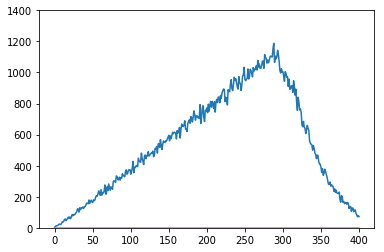

In [55]:
plt.plot(time,NB_proli,time,NB_mut)
matplotlib.pyplot.ylim(0,1400)

Time according to the number of quiscent cells in blue and necrotic cells in orange 

(0, 100000)

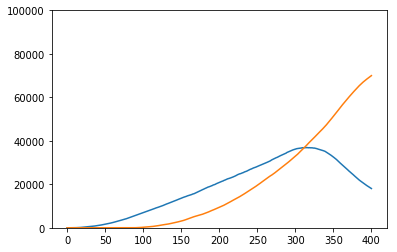

In [56]:
plt.plot(time,NB_Qui,time,NB_Necr)
matplotlib.pyplot.ylim(0,100000)